In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from flamespread import *
from dataset_handler import *
from IR_analysis import get_dewarp_parameters,sort_corner_points
import h5py
#reload
%load_ext autoreload

%autoreload 2

In [7]:
h5file =h5py.File('testing/PMMA_DE_6mm_RCE_1m_R1/processed_data/PMMA_DE_6mm_RCE_1m_R1_results_RCE.h5','a')

In [12]:
h5file['dewarped_data_left']['data'].shape[-1]

ValueError: Invalid location identifier (invalid location identifier)

In [3]:
h5file.keys()

<KeysViewHDF5 ['dewarped_data', 'dewarped_data_left', 'dewarped_data_right', 'edge_results', 'edge_results_left', 'edge_results_right']>

In [11]:
h5file.close()


In [83]:
import dataset_handler
from DataTypes import IrData

exp_name ='PMMA_DE_6mm_RCE_1m_R1_IR'
data =IrData(os.path.join(user_config.get_path('data_folder'), exp_name.replace('IR', "0001")))

In [84]:
dewarped_grp = dataset_handler.get_file(exp_name, 'a').get('dewarped_data', None)
if dewarped_grp is None:
    dewarped_grp = dataset_handler.get_file(exp_name, 'a').create_group('dewarped_data')
    dset = dewarped_grp.get('data', None)


dset = dewarped_grp['data']
metadata = dataset_handler.get_dewarped_metadata(exp_name)
data_numbers = data.data_numbers
dewarp_params = {}
start, end = metadata['frame_range']
dset_w = metadata['target_pixels_width']
dset_h = metadata['target_pixels_height']
dewarp_params['transformation_matrix'] = metadata['transformation_matrix']
dewarp_params['target_pixels_width'] = metadata['target_pixels_width']
dewarp_params['target_pixels_height'] = metadata['target_pixels_height']
dewarp_params['target_ratio'] = metadata['target_ratio']
dewarp_params['selected_points'] = metadata['selected_points']
dewarp_params['frame_range'] = metadata['frame_range']

start,end = 0 ,480

map_x = np.arange(0, dset_w, 1)
map_y = np.arange(0, dset_h, 1)
map_x, map_y = np.meshgrid(map_x, map_y)
transformation_matrix = np.linalg.inv(dewarp_params['transformation_matrix'])
src_x = (transformation_matrix[0, 0] * map_x + transformation_matrix[0, 1] * map_y + transformation_matrix[
    0, 2]) / (transformation_matrix[2, 0] * map_x + transformation_matrix[2, 1] * map_y + transformation_matrix[
    2, 2])
src_y = (transformation_matrix[1, 0] * map_x + transformation_matrix[1, 1] * map_y + transformation_matrix[
    1, 2]) / (transformation_matrix[2, 0] * map_x + transformation_matrix[2, 1] * map_y + transformation_matrix[
    2, 2])
if dewarped_grp.get('src_x', None) is not None:
    del dewarped_grp['src_x']
if dewarped_grp.get('src_y', None) is not None:
    del dewarped_grp['src_y']
dewarped_grp.create_dataset('src_x', data=src_x)
dewarped_grp.create_dataset('src_y', data=src_y)
assumed_pixel_error = 0.5
dewarped_grp.attrs['assumed_pixel_error'] = assumed_pixel_error
dewarped_grp.attrs['error_unit'] = 'pixels'
src_points = np.array([src_x.flatten(),src_y.flatten()]).reshape(*src_x.shape,-1)

# err_x = assumed_pixel_error/np.linalg.norm(np.diff(src_points,axis=0),axis=2)
# err_y = assumed_pixel_error/np.linalg.norm(np.diff(src_points,axis=1),axis=2)
#
# dewarped_grp.create_dataset('err_x', data=err_x)
# dewarped_grp.create_dataset('err_y', data=err_y)
src_x_map, src_y_map = cv2.convertMaps(src_x.astype(np.float32), src_y.astype(np.float32), cv2.CV_16SC2)

bar = progressbar.ProgressBar(max_value=len(data_numbers[start:end]))
for i, idx in bar(enumerate(data_numbers[start:end])):
    img = data.get_frame(idx)
    dewarped_data = cv2.remap(img, src_x_map, src_y_map, interpolation=cv2.INTER_LINEAR)
    # dset.resize((dset_h, dset_w, i + 1))
    dset[:, :, i] = dewarped_data
dataset_handler.close_file()

100% (480 of 480) |######################| Elapsed Time: 0:05:34 Time:  0:05:34


In [4]:
f = get_file('PMMA_DE_6mm_RCE_1m_R1_IR','a')


In [12]:
f['dewarped_data']['data']


<HDF5 dataset "data": shape (177, 913, 420), type "<f4">

In [6]:
f['dewarped_data'].attrs['target_ratio'] = 100/50
TARGET_RATIO = 100/50
selected_points = f['dewarped_data'].attrs['selected_points']

In [9]:

dewarp_params = get_dewarp_parameters(sort_corner_points(selected_points), target_ratio=TARGET_RATIO)

In [11]:
grp = f['dewarped_data']
grp.attrs['transformation_matrix'] = dewarp_params['transformation_matrix']
grp.attrs['target_pixels_width'] = dewarp_params['target_pixels_width']
grp.attrs['target_pixels_height'] = dewarp_params['target_pixels_height']


In [10]:
dewarp_params

{'transformation_matrix': array([[ 1.04011665e+00,  1.85074137e-03, -5.30579790e+02],
        [-4.93299015e-02,  1.02833872e+00, -4.16837667e+01],
        [-1.10995900e-04, -1.31855597e-05,  1.00000000e+00]]),
 'target_pixels_width': 309,
 'target_pixels_height': 618}

In [12]:
close_file()

In [14]:
exp_name ='lfs_pmma_DE_6mm_tc_R1_IR'
exp_name2 ='LFS_CN_6mm_R1_IR'

# dewarped_data1= h5py.File(os.path.join(user_config.get_path('saved_data'), exp_name + '.h5'), 'r')['dewarped_data']['data']
# dewarped_data2= h5py.File(os.path.join(user_config.get_path('saved_data'), exp_name2 + '.h5'), 'r')['dewarped_data']['data']
edge_results = get_edge_results(exp_name)
edge_results2 = get_edge_results(exp_name2)


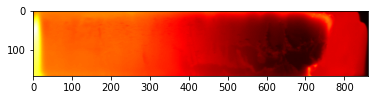

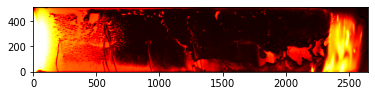

In [205]:
i =1000

plt.imshow(dewarped_data1[:,:,2*i],cmap='hot')
plt.show()
plt.figure()
plt.imshow(dewarped_data2[:,:,i+5],cmap='hot')
plt.gca().invert_yaxis()
plt.show()

In [16]:
import exifread
import glob
import os
from DataTypes import ImageData
import datetime
import pandas as pd
import numpy as np
import user_config as ucfg
from matplotlib import pyplot as plt

In [9]:
path = os.path.join(ucfg.get_path('canon_folder'), 'lfs_pmma_DE_6mm_tc_R2'.replace('_CANON', ''))

In [10]:
imgdata = ImageData(path,'JPG')


In [11]:
a = pd.to_datetime(str(exifread.process_file(open(imgdata.files[0],'rb'))['Image DateTime']),format='%Y:%m:%d %H:%M:%S').timestamp()
b= pd.to_datetime(str(exifread.process_file(open(imgdata.files[-1],'rb'))['Image DateTime']),format='%Y:%m:%d %H:%M:%S').timestamp()

In [12]:
times =[os.path.getmtime(i) for i in imgdata.files]
times.sort()

In [13]:
times = np.array(times)
times = times - times[0]

In [14]:
tags =exifread.process_file(open(imgdata.files[101],'rb'))

In [69]:
tags.keys()

dict_keys(['Image Make', 'Image Model', 'Image Orientation', 'Image XResolution', 'Image YResolution', 'Image ResolutionUnit', 'Image DateTime', 'Image Artist', 'Image YCbCrPositioning', 'Image Copyright', 'Image ExifOffset', 'GPS GPSVersionID', 'Image GPSInfo', 'Thumbnail Compression', 'Thumbnail XResolution', 'Thumbnail YResolution', 'Thumbnail ResolutionUnit', 'Thumbnail JPEGInterchangeFormat', 'Thumbnail JPEGInterchangeFormatLength', 'EXIF ExposureTime', 'EXIF FNumber', 'EXIF ExposureProgram', 'EXIF ISOSpeedRatings', 'EXIF SensitivityType', 'EXIF RecommendedExposureIndex', 'EXIF ExifVersion', 'EXIF DateTimeOriginal', 'EXIF DateTimeDigitized', 'EXIF ComponentsConfiguration', 'EXIF ShutterSpeedValue', 'EXIF ApertureValue', 'EXIF ExposureBiasValue', 'EXIF MeteringMode', 'EXIF Flash', 'EXIF FocalLength', 'EXIF MakerNote', 'EXIF UserComment', 'EXIF SubSecTime', 'EXIF SubSecTimeOriginal', 'EXIF SubSecTimeDigitized', 'EXIF FlashPixVersion', 'EXIF ColorSpace', 'EXIF ExifImageWidth', 'EXIF 

In [73]:
tags['EXIF SubSecTimeOriginal']

(0x9291) ASCII=27 @ 598

In [74]:
tags['EXIF DateTimeOriginal']

(0x9003) ASCII=2024:06:05 09:40:03 @ 838

In [78]:
timestamp = os.path.getmtime(imgdata.files[102])
time = datetime.datetime.fromtimestamp(timestamp)
time

datetime.datetime(2024, 6, 5, 9, 40, 4)

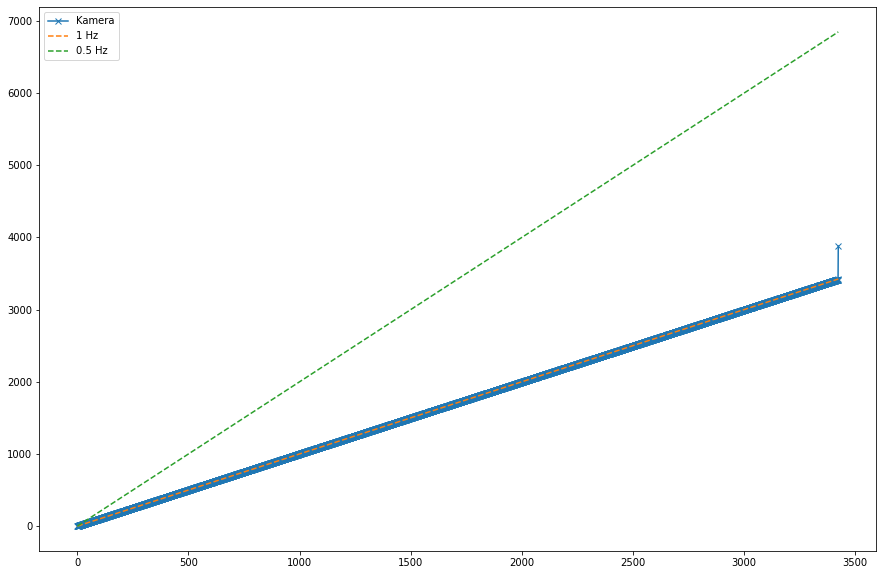

In [20]:
plt.figure(figsize=(15,10))
plt.plot(times,label='Kamera',marker = 'x',linestyle = None)
# plt.ylim(1000,1010)
plt.plot(np.array(range(len(times))),'--',label='1 Hz')
plt.plot(2*np.array(range(len(times))),'--',label='0.5 Hz')
plt.legend()

NameError: name 'edge_results' is not defined

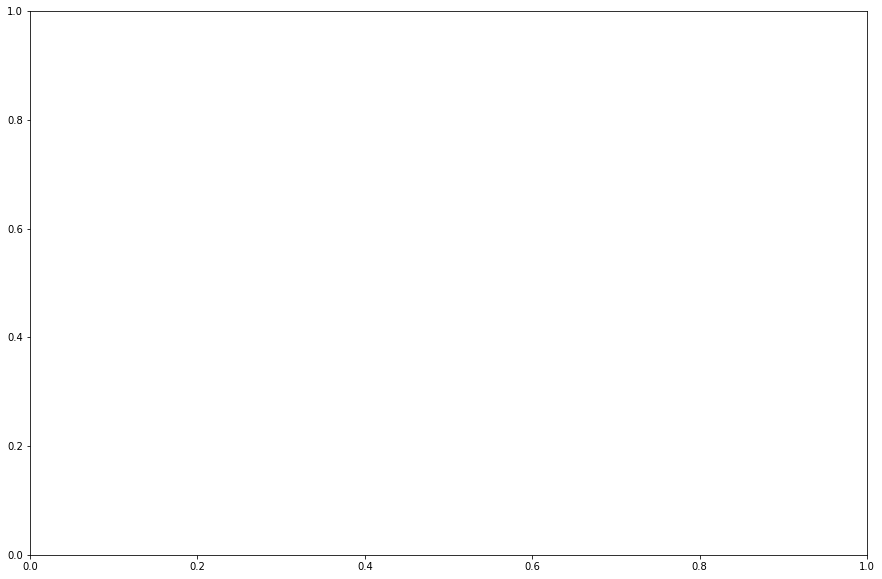

In [53]:

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
y1 = edge_results.shape[1]//2
y2 = edge_results2.shape[1]//2
y1 = -y1 -1
y2 = -y2 -1
ax.plot(edge_results.T[y1][235::10],label='DE at y = {}'.format(-y1))
ax.plot(edge_results2.T[y2][15:],label='CN at y = {}'.format(-y2))
ax.set_title('Flame spread at 50% height')
ax.set_xlabel('Frame')
ax.set_ylabel('X coordinate')
ax.legend()


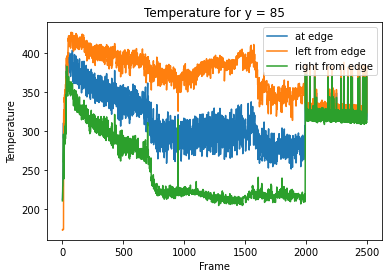

In [4]:
idx = edge_results1.T[85]
temp = dewarped_data[85,:,:]
plt.plot(temp[idx,range(len(idx))],label='at edge')
plt.plot(temp[idx-3,range(len(idx))],label='left from edge')
right_idx = [min(i+3,860) for i in idx]
plt.plot(temp[right_idx,range(len(idx))],label='right from edge')
plt.title('Temperature for y = 85')
plt.xlabel('Frame')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [5]:
import cv2

In [62]:

def calculate_edge_data_for_frame(frame,y_slice,data, find_edge_point, custom_filter=lambda x: x):
    # data = data[:,::-1]
    result = []
    bar = progressbar.ProgressBar()
    n = frame
    i = y_slice
    background_frame = data[:, :, max(n - 1, 0)]
    frame = data[:, :, n]
    frame_result = []
    filtered_frame = custom_filter(frame.copy())
    frame = filtered_frame - custom_filter(background_frame)
    cv2_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ret, thresh = cv2.threshold(cv2_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = cv2.dilate(thresh, None, iterations=10)
    start, end = 0, -1
    if n < 150:
        try:
            start, end = np.where(thresh[i, :] > 0)[0][[0, -1]]
            end +=10
        except IndexError:
            pass
    y = filtered_frame[i, start:end]
    peak = find_edge_point(y)
    if peak >0:
        peak += start
    frame_result.append(peak)
    result.append(frame_result)
    return result


In [50]:
exp_name ='test'
# exp_name2 ='lfs_pmma_DE_6mm_tc_R2_0001'
dewarped_data= get_dewarped_data(exp_name)[:]
edge_results1 = get_edge_results(exp_name)[:]
# edge_results2 = get_edge_results(exp_name2)


In [92]:
frame_number = 289
y_slice = 71

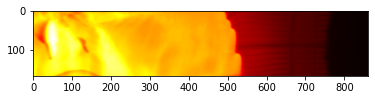

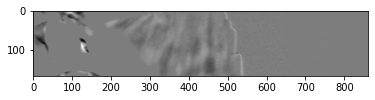

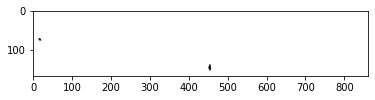

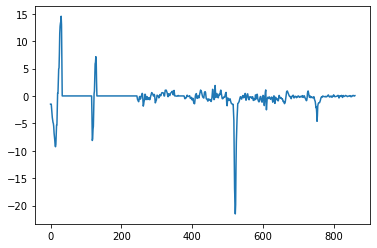

In [93]:
custom_filter = lambda x: band_filter(x,150,450)
# custom_filter = lambda x: x
background_frame =dewarped_data[:,:,frame_number-1]
org_frame = dewarped_data[:,:,frame_number]
frame =custom_filter(org_frame)
frame -= custom_filter(background_frame)

cv2_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
ret,thresh = cv2.threshold(cv2_frame,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh =cv2.dilate(thresh, None, iterations=10)
start,end = np.where(thresh[y_slice,:]>0)[0][[0,-1]]
# start +=10
end+=10
gradient = np.gradient(custom_filter(org_frame[y_slice,start:end]))
plt.imshow(org_frame,cmap='hot')
plt.figure()
plt.imshow(frame,cmap='gray')
plt.figure()
plt.imshow(thresh,cmap='gray')
plt.figure()
plt.plot(gradient)

In [180]:

highest_peak_to_lowest_value(custom_filter(org_frame[y_slice,start:end]),min_distance=5,min_height=1,min_width=2,ambient_weighting=2,high_val=320,low_val=380,previous_peak=300,previous_velocity=20) +start


[14, 522]
[-13.3  12.1]
[0.01668636 0.13342755]


522

In [171]:
    peak_method = lambda x: highest_peak_to_lowest_value(x, min_distance=10, min_height=1, min_width=2,
                                                         ambient_weighting=2, high_val=320, low_val=380)
calculate_edge_data_for_frame(frame_number,y_slice,dewarped_data,peak_method,custom_filter=lambda x: band_filter(x, low=150, high=450))

[[522]]

In [120]:
from scipy.stats import skewnorm

In [139]:
skewnorm.stats(3,moments='mvsk')

(0.7569397566060481,
 0.42704220486917677,
 0.6670235701524082,
 0.5097701294494134)

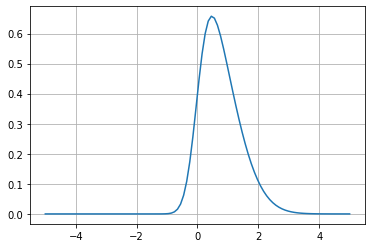

In [138]:
plt.plot(np.linspace(-5,5,100),skewnorm.pdf(np.linspace(-5,5,100),3))
plt.grid()

(167, 861)


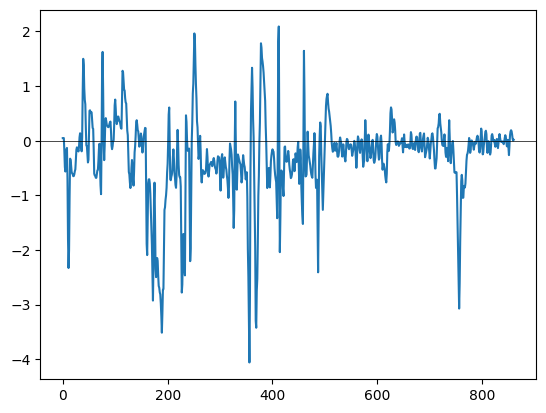

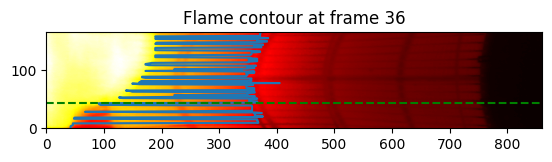

In [42]:
print(get_frame(dewarped_data,frame_number).shape)
y = 130
plot_gradient(get_frame(dewarped_data,frame_number),y)
show_flame_contour(dewarped_data,edge_results_rolled,frame_number)
plt.axhline(y=173-y, color='g', linestyle='--')
plt.show()

In [83]:
close_file()

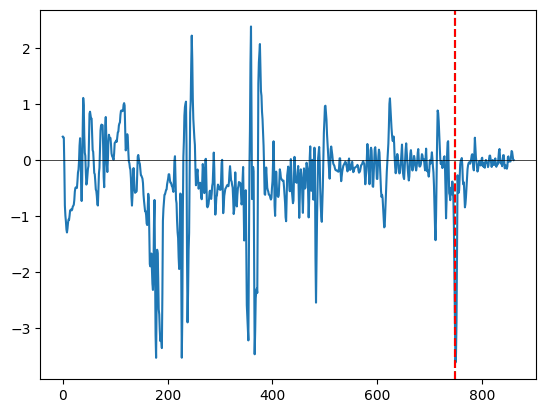

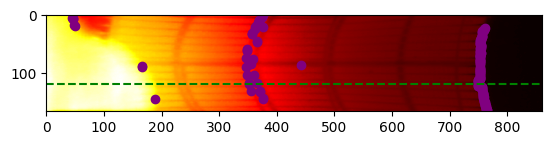

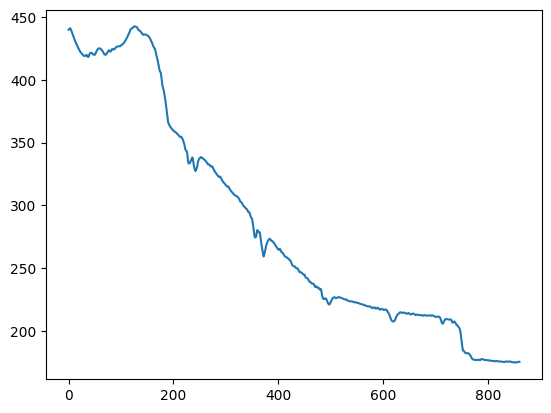

In [51]:
frame_number = 6
y = 122
ambient_weighting=1
frame = get_frame(dewarped_data,frame_number)
# frame = band_filter(frame,300,450)
y_data = frame[y,:]
plot_gradient(frame,y)
peak = highest_peak(y_data)
plt.axvline(x=peak, color='g', linestyle='--',label='highest')
peak = highest_peak_to_lowest_value(y_data,ambient_weighting=ambient_weighting)
plt.axvline(x=peak, color='r', linestyle='--',label='highest to lowest')
peak_method = lambda y_data: highest_peak_to_lowest_value(y_data,ambient_weighting=ambient_weighting,min_width=2)
plt.figure()
plot_edge(frame,peak_method)
plt.axhline(y=y, color='g', linestyle='--')
plt.figure()
plot_1D(frame,y)
plt.show()


In [34]:
import dataset_handler
dataset_handler.close_file()    